# SIM Hessian Anisotropy Measurement

In [16]:
import os
import tifffile
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, fftshift
import numpy as np
from sklearn.metrics import mutual_info_score

## Data Loading

In [2]:
# IMG_WF = "/mnt/Ceph/jacky/TIRFSIM/PixelSizeTIRFSIM20250331/att0.9/Angle_pw50pc100exp100NA1141(0)_WF.tif"
# IMG_SIM = "/mnt/Ceph/jacky/TIRFSIM/PixelSizeTIRFSIM20250331/att0.9/Angle_pw50pc100exp100NA1141(0)_HiFiSIM.tif"

# IMG_WF = "/mnt/Ceph/jacky/TIRFSIM/PixelSizeTIRFSIM20250331/att0.9/Grids_pw50pc100exp100NA1141(0)_WF.tif"
# IMG_SIM = "/mnt/Ceph/jacky/TIRFSIM/PixelSizeTIRFSIM20250331/att0.9/Grids_pw50pc100exp100NA1141(0)_HiFiSIM.tif"

# IMG_WF = "/mnt/Ceph/jacky/TIRFSIM/PixelSizeTIRFSIM20250331/att0.9/RingArray_pw50pc100exp100NA1141(0)_WF.tif"
# IMG_SIM = "/mnt/Ceph/jacky/TIRFSIM/PixelSizeTIRFSIM20250331/att0.9/RingArray_pw50pc100exp100NA1141(0)_HiFiSIM.tif"

IMG_WF = "/mnt/Ceph/jacky/TIRFSIM/PixelSizeTIRFSIM20250331/att0.9/Targetpw50pc100exp100NA1141 (1)_WF.tif"
IMG_SIM = "/mnt/Ceph/jacky/TIRFSIM/PixelSizeTIRFSIM20250331/att0.9/Targetpw50pc100exp100NA1141 (1)_HiFiSIM.tif"

In [3]:
img_wf = tifffile.imread(IMG_WF)
img_sim = tifffile.imread(IMG_SIM)

In [4]:
def compute_anisotropy(f_shifted, num_bins=360):
    rows, cols = f_shifted.shape
    center = (rows // 2, cols // 2)
    
    # Convert to polar coordinates
    y, x = np.ogrid[:rows, :cols]
    theta = np.arctan2(y - center[0], x - center[1])  # Angular direction
    theta = (theta + np.pi) % (2 * np.pi)  # Convert range to [0, 2*pi]
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)  # Radial distance
    
    power_spectrum = np.abs(f_shifted)**2
    # Group intensities by angle (discretize theta into bins)
    theta_bins = np.linspace(0, 2 * np.pi, num_bins)
    angular_intensity = np.zeros(num_bins - 1)
    
    for i in range(len(theta_bins) - 1):
        mask = (theta >= theta_bins[i]) & (theta < theta_bins[i + 1])
        angular_intensity[i] = np.sum(power_spectrum[mask])
    
    # Anisotropy: Standard deviation divided by mean of angular intensity
    anisotropy = np.std(angular_intensity) / (np.mean(angular_intensity) + 1e-6)  # Avoid division by zero
    return anisotropy, angular_intensity

Mutual Information: 0.3442


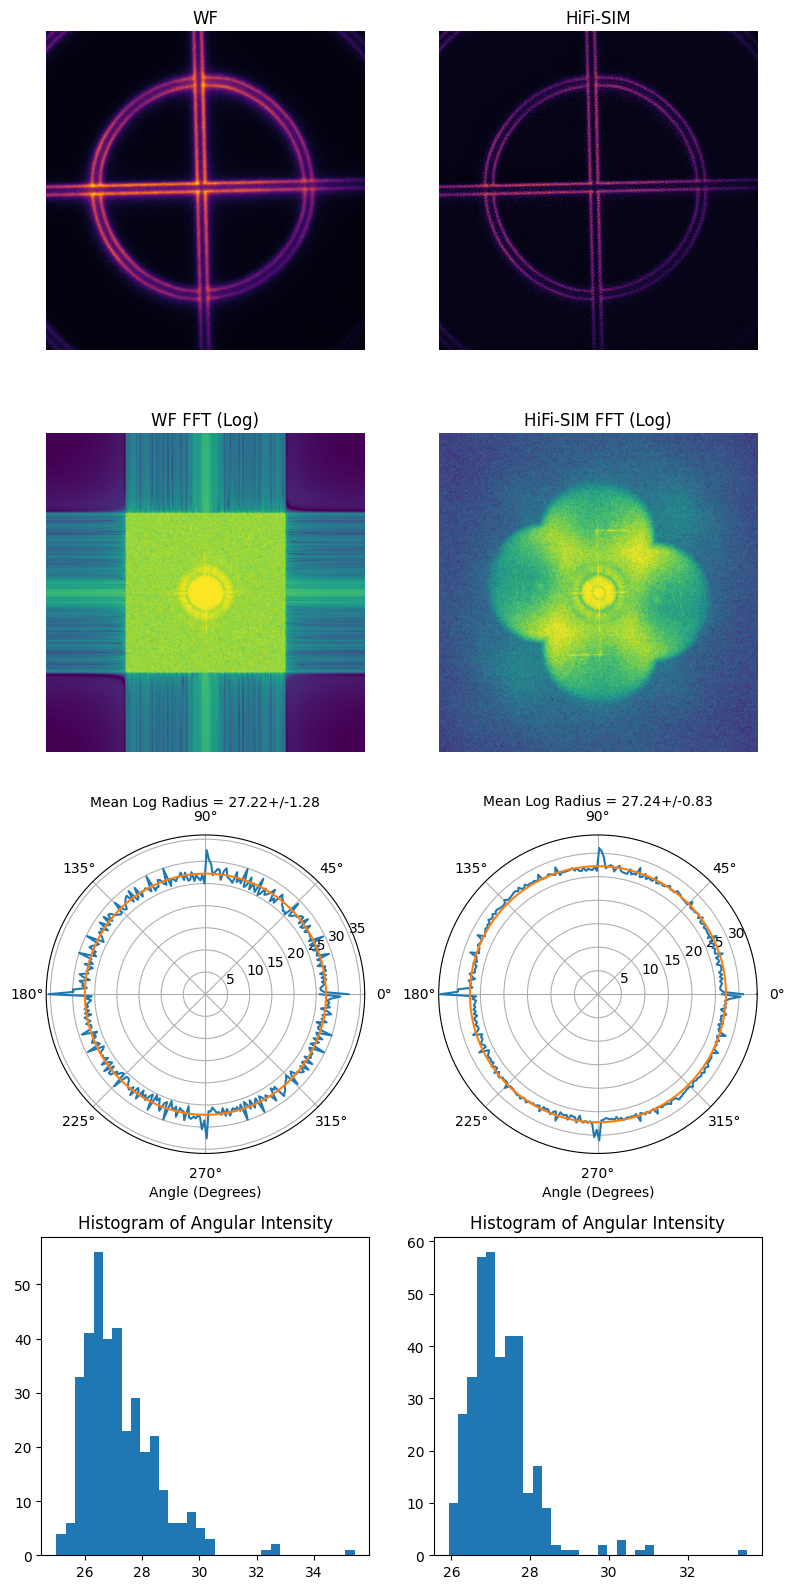

In [21]:
fig, axs = plt.subplots(4,2,figsize=(8,16))
axs[0,0].imshow(img_wf, cmap="inferno")
axs[0,0].set_title("WF")
axs[0,0].set_axis_off()

axs[0,1].imshow(img_sim, cmap="inferno")
axs[0,1].set_title("HiFi-SIM")
axs[0,1].set_axis_off()

f_transform = fft2(img_wf)
f_shifted = fftshift(f_transform)
power_spectrum = np.abs(f_shifted)**2
power_spectrum_log = np.log(1 + power_spectrum)

axs[1,0].imshow(power_spectrum_log, cmap="viridis", vmin=np.percentile(power_spectrum_log,1), vmax=np.percentile(power_spectrum_log,99))
axs[1,0].set_title("WF FFT (Log)")
axs[1,0].set_axis_off()

ANGULAR_BINS = int(360/1)
anisotropy, angular_intensity = compute_anisotropy(f_shifted, num_bins=ANGULAR_BINS)
# anisotropy, angular_intensity = compute_anisotropy(f_shifted[
#     int(f_shifted.shape[0]/4):int(f_shifted.shape[0]*3/4),
#     int(f_shifted.shape[1]/4):int(f_shifted.shape[1]*3/4),
#     ], num_bins=ANGULAR_BINS)
img_flat_wf = np.log(1+angular_intensity).flatten()

# Angular Intensity Distribution
axs[2,0].set_axis_off()
axs[2,0] = fig.add_subplot(4, 2, 5, projection='polar')
# axs[2,0].set_title('Angular Intensity Distribution')
axs[2,0].plot(np.linspace(0, 2*np.pi, len(angular_intensity)), np.log(1+angular_intensity))
axs[2,0].plot(np.linspace(0, 2*np.pi, len(angular_intensity)), [np.mean(np.log(1+angular_intensity))]*len(angular_intensity))
axs[2,0].text(np.pi/2,np.max(np.log(1+angular_intensity))*1.2,"Mean Log Radius = {:.2f}+/-{:.2f}".format(np.mean(np.log(1+angular_intensity)), np.std(np.log(1+angular_intensity))), horizontalalignment='center')
axs[2,0].set_xlabel('Angle (Degrees)')
# axs[2,0].set_ylabel('Intensity')

axs[3,0].hist(np.log(1+angular_intensity),bins=32)
axs[3,0].set_title("Histogram of Angular Intensity")

f_transform = fft2(img_sim)
f_shifted = fftshift(f_transform)
power_spectrum = np.abs(f_shifted)**2
power_spectrum_log = np.log(1 + power_spectrum)

axs[1,1].imshow(power_spectrum_log, cmap="viridis", vmin=np.percentile(power_spectrum_log,1), vmax=np.percentile(power_spectrum_log,99))
axs[1,1].set_title("HiFi-SIM FFT (Log)")
axs[1,1].set_axis_off()

anisotropy, angular_intensity = compute_anisotropy(f_shifted, num_bins=ANGULAR_BINS)
img_flat_sim = np.log(1+angular_intensity).flatten()

# Angular Intensity Distribution
axs[2,1].set_axis_off()
axs[2,1] = fig.add_subplot(4, 2, 6, projection='polar')
# axs[2,0].set_title('Angular Intensity Distribution')
# axs[2,1].plot(np.linspace(0, 2*np.pi, len(angular_intensity)), angular_intensity)
axs[2,1].plot(np.linspace(0, 2*np.pi, len(angular_intensity)), np.log(1+angular_intensity))
axs[2,1].plot(np.linspace(0, 2*np.pi, len(angular_intensity)), [np.mean(np.log(1+angular_intensity))]*len(angular_intensity))
axs[2,1].text(np.pi/2,np.max(np.log(1+angular_intensity))*1.2,"Mean Log Radius = {:.2f}+/-{:.2f}".format(np.mean(np.log(1+angular_intensity)), np.std(np.log(1+angular_intensity))), horizontalalignment='center')
axs[2,1].set_xlabel('Angle (Degrees)')
# axs[2,1].set_ylabel('Intensity')

axs[3,1].hist(np.log(1+angular_intensity),bins=32)
axs[3,1].set_title("Histogram of Angular Intensity")

fig.tight_layout()


# Compute individual histograms
hist1, bins1 = np.histogram(img_flat_wf, bins=256, range=(0, 35))
hist2, bins2 = np.histogram(img_flat_sim, bins=256, range=(0, 35))

# Compute joint histogram
joint_hist, _, _ = np.histogram2d(img_flat_wf, img_flat_sim, bins=32, range=[[0, 35], [0, 35]])

# Normalize to get joint probabilities
joint_prob = joint_hist / np.sum(joint_hist)

# Compute mutual information
mi = mutual_info_score(None, None, contingency=joint_hist)
print(f"Mutual Information: {mi:.4f}")